In [86]:
#Import
import pandas as pd
import cv2
import numpy as np
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gc



In [87]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [88]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [89]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
additional  = ['rt','rts','retweet'] # lista adicional de stopwords
swords = set().union(stopwords.words('english'),additional) # adicionando palavras para o stopwords

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:
path = "dataset_sidi_v1.2.csv"
path512 = "dataset_sidi_512.csv"

df512 = pd.read_csv(path512, sep='\t')
df512

,Unnamed: 0,Unnamed: 0.1,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,382583,382583,798338609870872577-2,0.774375,0.174701,0.050924,what does it look like i do for a living? (cra...,NEG,0,data/79833/798338609870872577-2.jpg,1280,722
1,443004,443004,802556641057054721-1,0.540009,0.304103,0.155888,No cheat just skill. #ClikerHeroes https://t.c...,NEG,0,data/80255/802556641057054721-1.jpg,707,1366
2,348885,348885,796032212407721984-1,0.513661,0.322456,0.163883,@KEILOin_DaTrunk I deleted https://t.co/qIhBkn...,NEG,0,data/79603/796032212407721984-1.jpg,1334,750
3,377487,377487,798011160532381696-1,0.712648,0.254173,0.033180,"""RT NYTFashion: How Nasty Gal went from an eBa...",NEG,0,data/79801/798011160532381696-1.jpg,561,1000
4,423703,423703,801181521679790080-1,0.713677,0.186854,0.099468,I hate this nigga lmaooo https://t.co/gPcyJfJESN,NEG,0,data/80118/801181521679790080-1.jpg,1334,750
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,108284,108284,769551952275509248-1,0.010517,0.886504,0.102978,RT @Alwas97: find someone who loves you like b...,NEU,1,data/76955/769551952275509248-1.jpg,1218,1078
11996,93186,93186,769486781158858753-1,0.065240,0.897818,0.036942,RT @MelbWritersFest: Helen Garner talking to @...,NEU,1,data/76948/769486781158858753-1.jpg,1491,2048
11997,298145,298145,783915769943973890-1,0.011468,0.925276,0.063257,Watch lesbian movie: https://t.co/jzJrDcnAwaSh...,NEU,1,data/78391/783915769943973890-1.jpg,1024,683
11998,260672,260672,783138720610476033-1,0.003072,0.957911,0.039016,Click here to watch the movie: https://t.co/A...,NEU,1,data/78313/783138720610476033-1.jpg,1024,682


In [91]:
#holdout 80/10/10
#Separando treino e parte para validação e teste
x_train, x_split_two, y_train, y_split_two = train_test_split( df512, df512['sent_image'], train_size=0.8,random_state=42)
#Separando teste e validação
x_val, x_test, y_val, y_test = train_test_split(x_split_two,y_split_two, train_size=0.5,random_state=42)

In [92]:
#tokenização
t  = Tokenizer()
t.fit_on_texts(df512['text'].tolist())

#Bi-LSTM
x_train_BiLSTM = t.texts_to_sequences(x_train['text'].tolist())
x_val_BiLSTM = t.texts_to_sequences(x_val['text'].tolist())
x_test_BiLSTM = t.texts_to_sequences(x_test['text'].tolist())

#VADER
x_test_VADER = x_test["text"]

##VGG19
x_train = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_train['image_path'].tolist()]
x_val = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_val['image_path'].tolist()]
x_test = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_test['image_path'].tolist()]
 

In [93]:
#Mudando o formato para suporta o softmax na rede
#saindo do formato [2] para [0,0,1]
y_train = to_categorical(y_train, num_classes=3)
#y_test = to_categorical(y_test, num_classes=3)

y_val = to_categorical(y_val, num_classes=3)

y_test = y_test.tolist()

## VADER

In [94]:
def tweet_to_VADER_sentiment(tweet):

    sid_obj = SentimentIntensityAnalyzer()
    
    text = re.sub("@[A-Za-z0-9_]+","", tweet) #remove menções
    text = re.sub("#[A-Za-z0-9_]+","", text)  # remove hashtag
   
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) 
    words = word_tokenize(text)
    
    words = [w for w in words if w not in stopwords.words("english")]

    sentiment_dict = sid_obj.polarity_scores(tweet)

        # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 2
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return  0
 
    else :
        return 1

In [95]:
y_pred_VADER = [tweet_to_VADER_sentiment(i) for i in x_test_VADER]

## Bi-LSTM


In [96]:
maxlen = 100
max_features = 10000
x_train_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_train_BiLSTM, maxlen=maxlen)
x_val_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_val_BiLSTM, maxlen=maxlen)
x_test_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_test_BiLSTM, maxlen=maxlen)

In [97]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

10893

In [98]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [99]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [100]:
#Arquitetura base da página https://keras.io/examples/nlp/bidirectional_lstm_imdb/
#Modificação feita na saida (3) e na acitivação da saida (solftmax)


inputs = keras.Input(shape=(None,), dtype="int32")

x = layers.Embedding(max_features, 128)(inputs)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,478,019
Trainable params: 1,478,019
Non-train

In [101]:
#Compilando com lr de 0.001
model.compile(Adam(learning_rate=0.001), "categorical_crossentropy", metrics=["accuracy"])

#fazneodo early top quando o loss da validação aumentar
es = EarlyStopping(monitor='val_loss', verbose=1, patience=1,restore_best_weights=True)

#treinando
history_BiLSTM = model.fit(x_train_BiLSTM, y_train, batch_size=300, epochs=20, validation_data=(x_val_BiLSTM, y_val),callbacks=[es])

Epoch 1/20
32/32 [==============================] - 4s 59ms/step - loss: 1.0016 - accuracy: 0.4790 - val_loss: 0.8609 - val_accuracy: 0.6625
Epoch 2/20
32/32 [==============================] - 1s 32ms/step - loss: 0.5243 - accuracy: 0.7997 - val_loss: 0.4258 - val_accuracy: 0.8475
Epoch 3/20
32/32 [==============================] - 1s 33ms/step - loss: 0.1670 - accuracy: 0.9465 - val_loss: 0.3849 - val_accuracy: 0.8658
Epoch 4/20
32/32 [==============================] - 1s 32ms/step - loss: 0.0689 - accuracy: 0.9803 - val_loss: 0.4682 - val_accuracy: 0.8617
Epoch 00004: early stopping


In [102]:
y_pred_BiLSTM = model.predict(x_test_BiLSTM)
y_pred_BiLSTM =(y_pred_BiLSTM>0.5)
y_pred_BiLSTM = np.argmax(y_pred_BiLSTM, axis=-1)


## VGG19 adaptada

In [103]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

875

In [104]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [105]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [106]:
width = 128
height = 128
channels = 3


In [107]:
base_model = VGG19(weights=None, include_top=False, input_shape=(width, height, channels))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [108]:
flatten_layer = layers.Flatten()
dense1 = layers.Dense(1028, activation='relu')
dense2 = layers.Dense(1028, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense1,
    dense2,
    prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1028)              8422404   
                                                                 
 dense_1 (Dense)             (None, 1028)              1057812   
                                                                 
 dense_2 (Dense)             (None, 3)                 3087      
                                                                 
Total params: 29,507,687
Trainable params: 29,507,687
Non-trainable params: 0
_________________________________________________________________


In [109]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [110]:
#busca os dados que estão listados em train_filenames
import random
def generate_data(train_filenames,train_labels, batch_size,width, height,channels):
    dim = (width, height)
    while True:
        
        mistura = list(zip(train_filenames, train_labels))
        random.shuffle(mistura)
        train_filenames, train_labels = zip(*mistura)
        
        for i in range(0,len(train_filenames),batch_size):
            
            if  i+batch_size > len(train_filenames):
                bs = len(train_filenames)%batch_size
            else:
                bs = batch_size
            
            X_train = np.zeros((int(bs), width, height, channels))
            aux =0

            dim = (width, height)

            for j in train_filenames[i:i+ bs]:
                X_train[aux] =  np.asarray(cv2.resize(cv2.imread(j), dim, interpolation = cv2.INTER_AREA) )
                aux = aux + 1
                
            #img = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255.
            img = preprocess_input( X_train) 
            
            yield (img, np.array(train_labels[i:i+ bs]))

In [111]:
#dobra para 48 pra vê se tanka

batch_size=36

validation_steps = int(len(x_val)/batch_size)+(0 if len(x_val)%batch_size==0 else 1)
steps_per_epoch = int(len(x_train)/batch_size)+(0 if len(x_train)%batch_size==0 else 1)
steps_per_epoch,validation_steps,batch_size

(267, 34, 36)

In [112]:
es = EarlyStopping(monitor='val_loss', patience=1,  restore_best_weights=True)
epocas = 500

history_VGG19 = model.fit( generate_data(x_train, y_train, batch_size,width, height,channels),
          validation_steps=validation_steps,steps_per_epoch=steps_per_epoch,
          callbacks=[es], batch_size=batch_size,  epochs=epocas,
          validation_data=generate_data(x_val,y_val, batch_size,width, height,channels))

Epoch 1/500
267/267 [==============================] - 283s 1s/step - loss: 1.0973 - accuracy: 0.3436 - val_loss: 1.0934 - val_accuracy: 0.3642
Epoch 2/500
267/267 [==============================] - 283s 1s/step - loss: 1.0924 - accuracy: 0.3699 - val_loss: 1.0907 - val_accuracy: 0.3800
Epoch 3/500
267/267 [==============================] - 285s 1s/step - loss: 1.0881 - accuracy: 0.3824 - val_loss: 1.0882 - val_accuracy: 0.3883
Epoch 4/500
267/267 [==============================] - 288s 1s/step - loss: 1.0844 - accuracy: 0.3913 - val_loss: 1.0890 - val_accuracy: 0.3683


In [113]:
##generator para teste pra tankar com rede maior
def generate_data_teste(train_filenames, batch_size,width, height,channels):
    dim = (width, height)
    while True:
        
        
        for i in range(0,len(train_filenames),batch_size):
            
            if  i+batch_size > len(train_filenames):
                bs = len(train_filenames)%batch_size
            else:
                bs = batch_size
            
            X_train = np.zeros((int(bs), width, height, channels))
            aux =0

            dim = (width, height)

            for j in train_filenames[i:i+ bs]:
                X_train[aux] =  np.asarray(cv2.resize(cv2.imread(j), dim, interpolation = cv2.INTER_AREA) )
                aux = aux + 1
                
           # img = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255.
            img = preprocess_input(X_train) 
            
            yield (img)

In [114]:
y_pred_vgg = model.predict(generate_data_teste(x_test,batch_size,width, height,channels),steps=validation_steps)

y_pred_vgg = np.argmax(y_pred_vgg, axis=-1)

## Resultados

In [130]:
labels_pred = pd.DataFrame()
labels_pred["VADER"] = y_pred_VADER
labels_pred["BiLSTM"] = y_pred_BiLSTM
labels_pred["BiLSTM_Peso_2"] = y_pred_BiLSTM
labels_pred["VGG"] = y_pred_vgg
labels_pred


,VADER,BiLSTM,BiLSTM_Peso_2,VGG
0,0,2,2,1
1,1,1,1,2
2,2,0,0,1
3,2,0,0,2
4,0,1,1,2
...,...,...,...,...
1195,2,1,1,2
1196,2,1,1,1
1197,2,2,2,1
1198,1,1,1,2


In [131]:
moda = labels_pred.mode(axis =1)
y_pred = moda[0].tolist()


In [132]:
#y_test = np.argmax(y_test, axis=-1)

print(accuracy_score(y_test, y_pred));
print(classification_report(y_test, y_pred));

0.8725
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       420
           1       0.89      0.80      0.84       374
           2       0.91      0.88      0.90       406

    accuracy                           0.87      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.88      0.87      0.87      1200



Negativo - 0     Neutro - 1      Positivo - 2


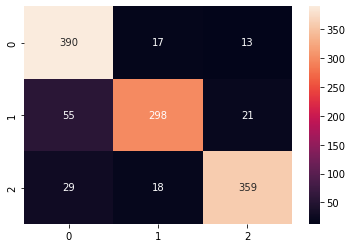

In [133]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d");

In [134]:
m = confusion_matrix(y_test, y_pred)
print("Acuracia de cada classe")
print("Negativo - 0     Neutro - 1      Positivo - 2")
m.diagonal()/m.sum(axis=1)

Acuracia de cada classe
Negativo - 0     Neutro - 1      Positivo - 2


array([0.92857143, 0.79679144, 0.88423645])